In [1]:
import tensorflow as tf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split 

In [2]:
path = 'E:/ZHOU/dsp_project/mel_spectrum/0/2.png'
img = load_img(path)
print(np.size(img,0))

128


In [31]:
path_train = "mel_spectrum"
num_pic = 0
x = np.zeros([1000, 128, 1280, 3])  # image different size, so only keep 1290
y = np.zeros(1000)
for folder in os.listdir(path_train):
    new_path = os.path.join(path_train, folder)
    for pic in os.listdir(new_path):
        img = load_img(os.path.join(new_path, pic))
        x[num_pic, :, :, :] = img_to_array(img)[:, 0:1280, :]
        y[num_pic] = int(folder)
        num_pic += 1
x = x/255.0
x_clip = x[:, :, 0:128, :]
y_clip = np.copy(y)
for k in range(1, 10):
    x_expand = x[:, :, k*128:(k+1)*128, :]
    x_clip = np.concatenate((x_clip, x_expand), axis=0)
    y_clip = np.concatenate((y_clip, y))
 # split into 10 clips, then datasets become 10000
X_train, x_test, Y_train, y_test = train_test_split(x_clip, y_clip, test_size=0.1)



In [36]:
# save the dataset into files, fix the test and train file 
# read 1D/2D savetxt high dimension: np.save read:np.load
np.save("X_train", X_train)
np.save("Y_train", Y_train)
np.save("x_test", x_test)
np.save("y_test", y_test)


In [28]:
# split into training set and validation set
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
x_test= np.load('x_test.npy')
y_test = np.load('y_test.npy')
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from keras import Sequential
import einops
class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if np.mod(epoch, 80) ==0 :  # or save after some epoch, each k-th epoch etc.
            self.model.save("lstm_model_save/model_{}".format(epoch))

In [22]:
class model_selection():
        def __init__(self, LSTM_shape=(128, 128*3), CNN_shape=(128,128,3), LSTM=False, CNN=False):
                self.LSTM_shape = LSTM_shape
                self.CNN_shape = CNN_shape
                self.LSTM = LSTM
                self.CNN = CNN

                
        def lstm(self):
                self.md = Sequential([
                        LSTM(128, input_shape = self.LSTM_shape, return_sequences=True),
                        LSTM(256),
                        Dropout(0.3),
                        Dense(128, activation='relu'),
                        Dropout(0.3),
                        Dense(10, activation='softmax')     
                ])

        def cnn(self):     
                self.md = Sequential([
                        Conv2D(filters=16, kernel_size=(3, 3), strides=(2,2), activation='relu', input_shape=self.CNN_shape, padding='same'),
                        MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
                        Dropout(0.3),
                        Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), activation='relu',padding='same'),
                        MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
                        Dropout(0.3),
                        Conv2D(filters=64, kernel_size=(3, 3), strides=(2,2), activation='relu',padding='same'),
                        MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
                        Dropout(0.3),
                        Conv2D(filters=128, kernel_size=(3, 3), strides=(2,2), activation='relu',padding='same'),
                        MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
                        Flatten(),
                        Dropout(0.3),
                        Dense(1024, activation='relu'),
                        Dropout(0.3),
                        Dense(10, activation='softmax')])
        
        def Compile(self, rate):
                opt = tf.keras.optimizers.Adam(learning_rate = rate)
                self.md.compile(optimizer=opt,
                loss="sparse_categorical_crossentropy",
                metrics='accuracy')

        def Fit(self, x_train, y_train, x_val, y_val):
                log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
                saver = CustomSaver()
                if self.CNN:
                        self.md.fit(x=x_train,
                        y=y_train,
                        epochs=100,
                        batch_size=128,
                        validation_data=(x_val, y_val),
                        shuffle=True,
                        callbacks=[tensorboard_callback, saver])
                if self.LSTM:
                        x_train = einops.rearrange(x_train, 'b h w c -> b w (h c)') # rearrange the dimension of an image as a vector
                        x_val = einops.rearrange(x_val, 'b h w c -> b w (h c)')
                        self.md.fit(x=x_train,
                        y=y_train,
                        epochs=100,
                        batch_size=128,
                        validation_data=(x_val, y_val),
                        shuffle=True,
                        callbacks=[tensorboard_callback, saver])


In [ ]:

q = model_selection(LSTM_shape=(128,128*3), CNN_shape=(128,128,3), LSTM=True)
# if q.LSTM:
#     x_test = einops.rearrange(x_test, 'b h w c -> b w (h c)')
q.lstm()
q.Compile(rate=1e-3)
q.Fit(x_train, y_train, x_val, y_val)
%tensorboard --logdir logs/fit
q.md.summary()

In [25]:
#  calculate the accuracy
# q.md.save(filepath='lstm_model_save/model_80')
model = tf.keras.models.load_model("lstm_model_save/model_80")
tf.keras.utils.plot_model(model, to_file='lstm_model_save/model_lstm.png', show_shapes=True, show_dtype=True
                          , show_layer_names=False, show_layer_activations=True)
print(x_test.shape)
scores = model.evaluate(x_test,y_test)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

(1000, 128, 384)
32/32 [==============================] - 4s 119ms/step - loss: 0.5988 - accuracy: 0.8570
Test loss: 0.5987834930419922
Test accuracy: 0.8569999933242798


32/32 [==============================] - 1s 15ms/step


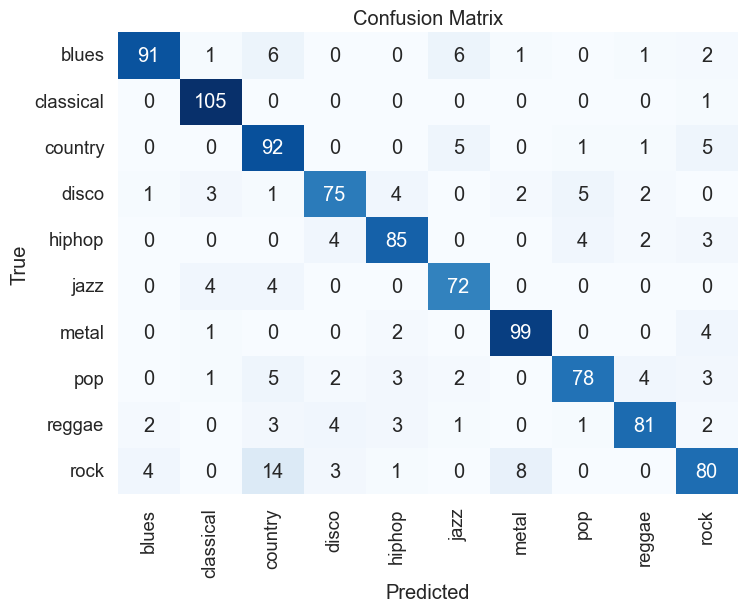

In [30]:
# predict and plot
from sklearn.metrics import confusion_matrix
import seaborn as sns
model = tf.keras.models.load_model("cnn_model_save/model_100")
y_pred = model.predict(x_test)
y_pred =np.argmax(y_pred, axis=1)
# define classes
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
